# **Dependencies**

In [0]:
import librosa
from scipy.io import wavfile
import scipy
import numpy as np
import os
from os.path import join
import numpy as np
!pip install pyworld
import pyworld as pw
import tensorflow as tf
import matplotlib.pyplot as plt





In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# **Parameters**

In [0]:
EPSILON = 1e-10
SETS = ['Training Set', 'Testing Set']  # TODO: for VCC2016 only
SPEAKERS = [s.strip() for s in tf.io.gfile.GFile('/content/drive/My Drive/speakers.tsv', 'r').readlines()]
FFT_SIZE = 1024
SP_DIM = FFT_SIZE // 2 + 1 # =513
FEAT_DIM = SP_DIM + SP_DIM + 1 + 1 + 1  # [sp, ap, f0, en, s] = 1029
RECORD_BYTES = FEAT_DIM * 4  # all features saved in `float32` = 4116
f0_ceil = 500

# **wav2pw() function**
The pyworld package and its subpackages (dio, stonemask, cheaptrick and d4c) would return the spectral envelope (SP), aperiodocity (AP), fundamental frequency (f0) of the specified {}.wav file. \\
The f0 ceiling is set such that we only filter the lower frequencies. There would be 513 instances of SP and 513 instances of AP.

In [0]:
def wav2pw(x, fs=16000, fft_size=FFT_SIZE):
    _f0, timeaxis = pw.dio(x, fs, f0_ceil = f0_ceil) # _f0 = Raw pitch
    f0 = pw.stonemask(x, _f0, timeaxis, fs)  # f0 = Refined pitch
    sp = pw.cheaptrick(x, f0, timeaxis, fs, fft_size=fft_size) # sp = spectogram spectral smoothing
    ap = pw.d4c(x, f0, timeaxis, fs, fft_size=fft_size) # extract aperiodicity
    return {
      'f0': f0,
      'sp': sp,
      'ap': ap,
    }
    


# **analysis() function**

In this function, we use the librosa package to acquire the amplitude and sampling rate of the audio file. The amplitude is then being used by the wav2pw() module. We add in a normalizing factor (summation of SP + epsilon), and refined the spectrogram of the spectral envelope on a logarithm scale.

Each single audio file would have a varying length of fundamental frequency depending on the length of the audio. For example: For SF1/100001.wav, we have 704 instances of f0. While for SF1/100002.wav, we have 216 instances of f0. This is because the audio duration for SF1/100001.wav is longer than SF1/100001.wav. However, the featured dimensions remain the same: For each instance of f0, we still have 513 instances of SP and 513 instances of AP.

In [0]:
def analysis(filename, fft_size=FFT_SIZE, dtype=np.float32):
    ''' Basic (WORLD) feature extraction ''' 
    fs = 16000
    x, _ = librosa.load(filename, sr=fs, mono=True, dtype=np.float64) #audio time series, sampling rate
    features = wav2pw(x, fs=16000, fft_size=fft_size)
    ap = features['ap']
    f0 = features['f0'].reshape([-1, 1]) #rows = unknown, columns = 1
    sp = features['sp']
    en = np.sum(sp + EPSILON, axis=1, keepdims=True) # Normalizing Factor
    sp_r = np.log10(sp / en) # Refined Spectrogram Normalization
    target = np.concatenate([sp_r, ap, f0, en], axis=1).astype(dtype)
    return target #add elements together based on position. Target for this file has 704 rows and 1028 columns

# **Example (Visualization of Spectral Envelope)**

In [0]:
filename1 = '/content/drive/My Drive/dataset/vcc2016/wav/Training Set/SF1/100002.wav'
a = analysis(filename1, fft_size=FFT_SIZE, dtype=np.float32)
x, _ = librosa.load(filename1, sr=16000, mono=True, dtype=np.float64)
b =wav2pw(x, fs=16000, fft_size=FFT_SIZE)

 Example: At a fundamental frequency of: 212.43134419873914 Hz, The spectral envelope is as shown: [<matplotlib.lines.Line2D object at 0x7f704e478048>]


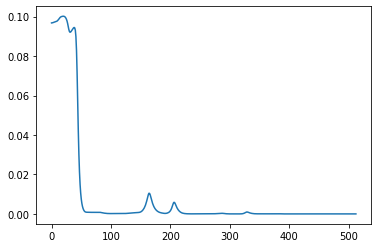

In [8]:
print(" Example: At a fundamental frequency of:", b['f0'][38], "Hz, The spectral envelope is as shown:", plt.plot(b['sp'][38]))